In [1]:
import torch
import math

from jinja2 import optimizer
from torch import nn as nn
from torch.nn import functional as F

In [2]:
def count_parameters(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SmallVae(nn.Module):
    def __init__(self, image_channels, base_channels, latent_dim):
        super(SmallVae, self).__init__()
        # encoder
        self.encoders = nn.ModuleList([
            nn.Conv2d(image_channels, base_channels, 4, 2, 1),
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),

        ])

        # latent space
        flat_dim = base_channels*4*32*32

        # calculate mu and var
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # decoder layers
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        self.decoders = nn.ModuleList([

            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1),
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1),
            nn.ConvTranspose2d(base_channels, image_channels, 4, 2, 1),
        ])

    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps*std + mu

    def forward(self, x):
        for conv in self.encoders:
            x = F.relu(conv(x))
        batch, c, h, w = x.shape
        x = x.view(batch, -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparam(mu, logvar)

        x = self.fc_dec(z).view(batch, c, h, w)
        for convd in self.decoders[:-1]:
            x = F.relu(convd(x))
        x = torch.sigmoid(self.decoders[-1](x))

        return x, mu, logvar

        #
class ChanedVae(nn.Module):
    def __init__(self, num_vaes, in_channels=3, C_ref=64, Z_ref=128):
        super(ChanedVae, self).__init__()

        # scale factor
        s = 1.0 / math.sqrt(num_vaes)
        c = max(1, int(C_ref * s))
        z = max(1, int(Z_ref * s))

        self.small_vaes = nn.ModuleList([
            SmallVae(in_channels, c, z) for _ in range(num_vaes)
        ])

    def forward(self, x):
        mus, logvars = [], []
        out = x
        for small_vae in self.small_vaes:
            out, mu, logvar = small_vae(out)
            mus.append(mu); logvars.append(logvar)
        return out, mus, logvars



for N in range(1, 10):
    m = ChanedVae(num_vaes=N, in_channels=3, C_ref=64, Z_ref=128)
    print(f"num_vaes={N:>1} → params: {count_parameters(m):,}")


recon_criterium = nn.MSELoss(reduction='mean')

def mse_loss(recon, target, mus, logvars):
    return recon_criterium(recon, target)





num_vaes=1 → params: 102,243,203
num_vaes=2 → params: 101,207,346
num_vaes=3 → params: 98,577,015
num_vaes=4 → params: 102,512,396
num_vaes=5 → params: 99,901,505
num_vaes=6 → params: 101,634,330
num_vaes=7 → params: 101,087,301
num_vaes=8 → params: 99,300,296
num_vaes=9 → params: 99,607,185


In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from matplotlib import pyplot as plt

In [4]:
def unnormalize(img_tensor):
    img_tensor_un = img_tensor.clone()
    img_tensor_un = img_tensor_un * 0.5 + 0.5
    img_tensor_un = img_tensor_un.clamp(0, 1)
    return img_tensor_un

def show_pair(inputs, targets, num_images = 1):
    inputs = inputs.cpu()
    targets = targets.cpu()

    plt.figure(figsize=(10, 4*num_images))
    for i in range(num_images):
        inp = unnormalize(inputs[i])
        tgt = unnormalize(targets[i])
        # Input image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(inp.permute(1, 2, 0))  # (C,H,W) -> (H,W,C)
        plt.title('Input (Noisy)')
        plt.axis('off')

        # Output/target image
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(tgt.permute(1, 2, 0))
        plt.title('Target (Clean)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

class PariedImages(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.input_dir = os.path.join(root, 'output')
        self.output_dir = os.path.join(root, 'input')
        self.input_files = sorted(os.listdir(self.input_dir))
        self.output_files = sorted(os.listdir(self.output_dir))
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])

        input_img = Image.open(input_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        return input_img, output_img

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



In [5]:
train_dataset = PariedImages('db/dataset_preprocessed/train', transform=transform)
val_dataset = PariedImages('db/dataset_preprocessed/val', transform=transform)
test_dataset = PariedImages('db/dataset_preprocessed/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/home/maciejka/Desktop/school/S8/labwork-project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])
tensor(1.)


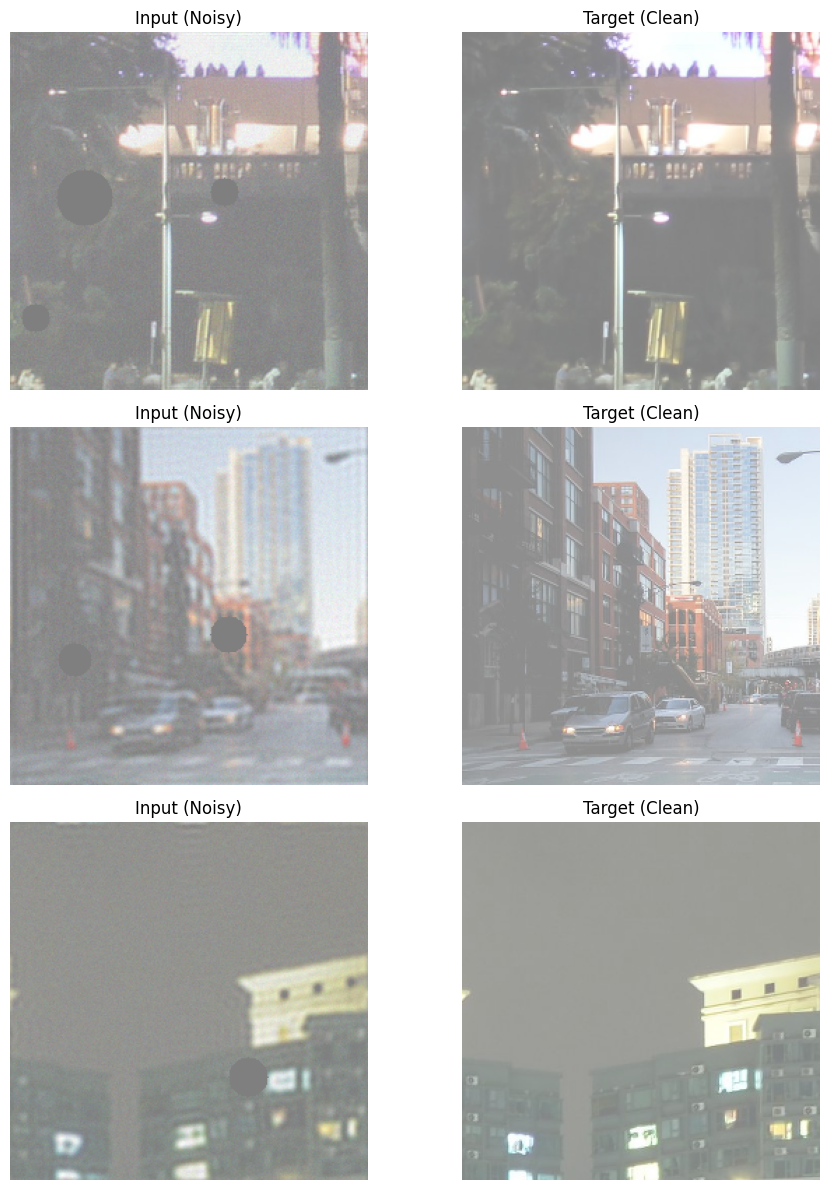

In [6]:

inputs, outputs = next(iter(train_loader))
print(inputs.shape, outputs.shape)
print(inputs[1][1].max())

show_pair(inputs, outputs, 3)

In [7]:
import time
from tqdm import tqdm
import torch.optim as optim
import pandas as pd

def train_model(device, n_stacks, n_epochs):
    timex = time.time()
    history = {'loss': [], 'val_loss': [], 'time': []}
    best_val_loss = float('inf')
    model = ChanedVae(num_vaes=n_stacks, C_ref=64, Z_ref=128)
    print(f'{count_parameters(model):,}')

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)



    for epoch in range(n_epochs):

        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}', leave=False)
        for noisy_imgs, clean_imgs in loop:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            recon_imgs, mus, logvars = model(noisy_imgs)
            loss = mse_loss(recon_imgs, clean_imgs, mus, logvars)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix({'Train loss': train_loss / (loop.n + 1)})

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs = noisy_imgs.to(device)
                clean_imgs = clean_imgs.to(device)

                recon_imgs, mus, logvars = model(noisy_imgs)
                loss = mse_loss(recon_imgs, clean_imgs, mus, logvars)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        time_epoch = time.time() - timex

        history['loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['time'].append(time_epoch)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

    return model, history

In [10]:
# training
dev = 'cpu' # or 'amdgpu' or "nvgpu"
n_epochs = 50
n_stacks = 1


# if cpu
if dev == 'cpu':
    device = torch.device('cpu')
# if amd gpu
elif dev == 'amdgpu':
    import torch_directml
    device = torch_directml.device()

elif dev == 'nvgpu':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print('using {}'.format(device))

for n_stacks in range(1, 10):
    name_model = "model_{}stacks.pth".format(n_stacks)
    name_history = "history_{}stacks.csv".format(n_stacks)

    model, data = train_model(device, n_stacks, n_epochs)

    torch.save(model.state_dict(), name_model)
    df = pd.DataFrame.from_dict(data)
    df.insert(0, 'epoch', df.index + 1)
    df.to_csv(name_history, index = False)






using cpu
102,243,203


Epoch 1/50:   0%|          | 0/80 [00:00<?, ?it/s]/home/maciejka/Desktop/school/S8/labwork-project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

       x         y             t
0      0  0.000000  1.746128e+09
1      1  0.841471  1.746128e+09
2      2  0.909297  1.746128e+09
3      3  0.141120  1.746128e+09
4      4 -0.756802  1.746128e+09
..   ...       ...           ...
995  995  0.773833  1.746128e+09
996  996 -0.114875  1.746128e+09
997  997 -0.897967  1.746128e+09
998  998 -0.855473  1.746128e+09
999  999 -0.026461  1.746128e+09

[1000 rows x 3 columns]
RangeIndex(start=0, stop=1000, step=1)


In [41]:
model = ChanedVae(num_vaes=2, C_ref=64, Z_ref=128)
model.load_state_dict(torch.load('models/model_2stacks.pth', map_location=torch.device('cpu')))

model.eval()

ChanedVae(
  (small_vaes): ModuleList(
    (0-1): 2 x SmallVae(
      (encoders): ModuleList(
        (0): Conv2d(3, 45, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): Conv2d(45, 90, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (2): Conv2d(90, 180, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
      (fc_mu): Linear(in_features=184320, out_features=90, bias=True)
      (fc_logvar): Linear(in_features=184320, out_features=90, bias=True)
      (fc_dec): Linear(in_features=90, out_features=184320, bias=True)
      (decoders): ModuleList(
        (0): ConvTranspose2d(180, 90, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ConvTranspose2d(90, 45, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (2): ConvTranspose2d(45, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
    )
  )
)

In [141]:
img = Image.open('db/dataset_preprocessed/test/output/118_24.bmp')

input_tensor = transform(img).unsqueeze(0)



In [142]:
with torch.no_grad():
    output_tensor, mu, logvar  = model(input_tensor)

print(output_tensor)
print("Output range before sigmoid:", output_tensor.min().item(), output_tensor.max().item())

tensor([[[[0.5501, 0.6983, 0.6954,  ..., 0.7678, 0.8020, 0.6174],
          [0.6646, 0.6357, 0.6648,  ..., 0.8369, 0.8639, 0.7977],
          [0.6342, 0.6807, 0.7151,  ..., 0.8651, 0.8569, 0.7935],
          ...,
          [0.5349, 0.6407, 0.6586,  ..., 0.4987, 0.5317, 0.5626],
          [0.5498, 0.6018, 0.6297,  ..., 0.4810, 0.5320, 0.6350],
          [0.4055, 0.4909, 0.4685,  ..., 0.5360, 0.6055, 0.5364]],

         [[0.4510, 0.4901, 0.5082,  ..., 0.6053, 0.6364, 0.5651],
          [0.4403, 0.3929, 0.4464,  ..., 0.6954, 0.6486, 0.6249],
          [0.4620, 0.4545, 0.4742,  ..., 0.6818, 0.7103, 0.6534],
          ...,
          [0.3249, 0.4205, 0.3077,  ..., 0.2897, 0.3176, 0.3965],
          [0.3377, 0.3030, 0.4411,  ..., 0.3185, 0.3296, 0.3763],
          [0.3854, 0.3330, 0.3156,  ..., 0.2951, 0.3046, 0.4036]],

         [[0.3033, 0.2873, 0.2982,  ..., 0.3271, 0.4444, 0.3733],
          [0.2604, 0.1962, 0.2213,  ..., 0.3286, 0.3257, 0.3507],
          [0.2738, 0.2187, 0.2197,  ..., 0

In [143]:
#output_img = (output_tensor.squeeze(0) * 0.5 + 0.5).clamp(0, 1)

output_img = output_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

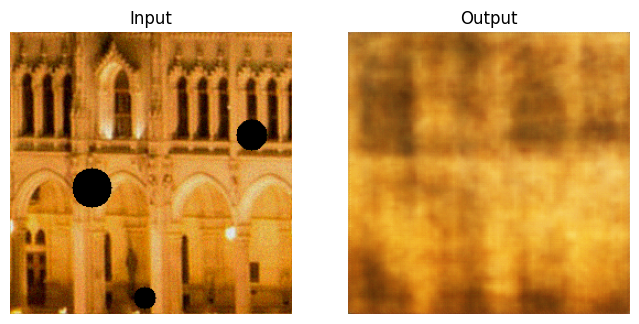

In [144]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(output_img)
plt.title("Output")
plt.axis('off')
plt.show()

0 - 0.5637770728707384
1 - 0.704295485445219
2 - 0.6930703578925071
3 - 0.8221514974133144
4 - 0.4321412491333831
5 - 0.669723808517772
6 - 0.6055658908820006
7 - 0.5224443179291064
8 - 0.5667322763764986
9 - 0.5552335592304369
10 - 0.44910462522548533
11 - 0.33083447195003657
12 - 0.4476302233708203
13 - 0.22863535553428577
14 - 0.8935320644469227
15 - 0.9090998155662527
16 - 0.9161907464634882
17 - 0.5507615767824268
18 - 0.7767212807558944
19 - 0.31534265079522317
20 - 0.44948187992822025
21 - 0.3544450036376686
22 - 0.2556800390894232
23 - 0.8051652415061002
24 - 0.6879354852772823
25 - 0.1789215320451427
26 - 0.68441101641957
27 - 0.49761039539575486
28 - 0.5694393794781432
29 - 0.41229404596351293
30 - 0.6840930308061492
31 - 0.5395161366311833
32 - 0.39800232535778574
33 - 0.7840659610024757
34 - 0.9150563733553243
35 - 0.3671736761901563
36 - 0.7771831845076941
37 - 0.86947527231487
38 - 0.7394265926151525
39 - 0.7060026361075228
40 - 0.11388384866382523
41 - 0.6686269080816565

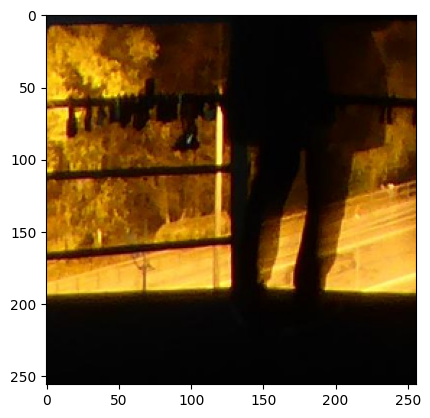

In [145]:
import glob
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

input_images = sorted(glob.glob('db/dataset_preprocessed/test/output/*.bmp'))
gt_images = sorted(glob.glob('db/dataset_preprocessed/test/input/*.bmp'))

#input_tensor = transform(img).unsqueeze(0)
i = 0

data_out = {
    'image': [],
    'ssim': []
}

for gt, broken in zip(gt_images, input_images):
    data_out['image'].append(gt)
    broken_img = Image.open(broken)

    input_tensor = transform(broken_img).unsqueeze(0)
    with torch.no_grad():
        output_tensor, mu, logvar  = model(input_tensor)
    output_img = output_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    gt_img = cv2.imread(gt)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

    output_img = np.round(output_img * 255).astype(np.uint8)

    sim = ssim(gt_img, output_img, multichannel=True, win_size=3)
    print('{} - {}'.format(i, sim))
    data_out['ssim'].append(sim)

    i += 1


data_out = pd.DataFrame.from_dict(data_out)
data_out.to_csv('n2.csv', index = False)

plt.imshow(gt_img)


                                               image      ssim
0      db/dataset_preprocessed/test/input/166_24.bmp  0.991104
1      db/dataset_preprocessed/test/input/189_34.bmp  0.986582
2      db/dataset_preprocessed/test/input/166_20.bmp  0.975974
3       db/dataset_preprocessed/test/input/675_5.bmp  0.968877
4      db/dataset_preprocessed/test/input/144_42.bmp  0.967433
...                                              ...       ...
1087   db/dataset_preprocessed/test/input/262_80.bmp  0.060484
1088    db/dataset_preprocessed/test/input/88_17.bmp  0.047681
1089    db/dataset_preprocessed/test/input/581_6.bmp  0.033728
1090  db/dataset_preprocessed/test/input/262_147.bmp  0.016039
1091    db/dataset_preprocessed/test/input/513_2.bmp -0.346363

[1092 rows x 2 columns]


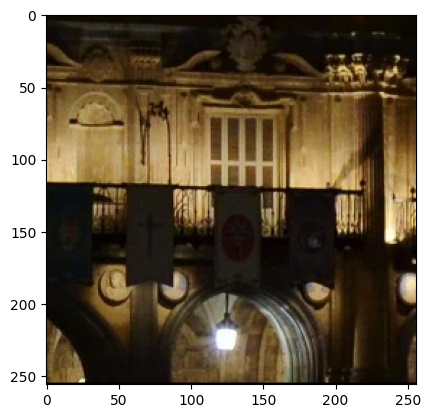

In [167]:
data_out = data_out.sort_values(by='ssim', ascending=False).reset_index(drop=True)
print(data_out)
plt.imshow(plt.imread(data_out['image'][312]))